# Discriminant analysis

In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

## Question 1
>The `covariance` function makes it possible to build a $2 \times 2$ covariance matrix based on spreads $\sigma_1$ and $\sigma_2$, and an angle $\theta$.

In [2]:
def covariance(sigma1=1., sigma2=1., theta=0.):
    """
        Covariance matrix with eigenvalues sigma1 and sigma2, rotated by the angle theta.
    """
    rotation = np.array([[np.cos(theta), -np.sin(theta)],
                        [np.sin(theta), np.cos(theta)]])
    cov = np.array([[sigma1, 0.],
                   [0, sigma2]])
    return rotation.dot(cov.dot(rotation.T))

In [3]:
print(covariance(sigma1=1, sigma2=3, theta=0))

[[1. 0.]
 [0. 3.]]


In [4]:
print(covariance(sigma1=1, sigma2=3, theta=np.pi/4))

[[ 2. -1.]
 [-1.  2.]]


>Either with the function `multivariate_normal` or with the Cholesky decomposition of a $2 \times 2$ covariance matrix $\Sigma$ (`L = np.linalg.cholesky(U)` produces a lower triangular matrix `L` such that `U = L @ L.T`), write a function that generates a multivariate Gaussian $n$-sample of mean $\mu \in \mathbb R^2$ and covariance $\Sigma$.
The corresponding numpy array should be of size $(n, 2)$.
>
>Compute the mean and the empirical covariance of the sample using Numpy routines.

In [5]:
# Answer
def gaussian_sample(mu=[0, 0], sigma1=1., sigma2=1., theta=0., n=50):
    # To do
    cov = covariance(sigma1, sigma2, theta)
    x = multivariate_normal.rvs(mean=mu, cov=cov, size=n)
    # End to do
    return x

# To do
X = gaussian_sample(sigma1=1, sigma2=10, theta=np.pi/6, n=1000)

print("Mean:", X.mean(axis=0))
print("Covariance:\n", covariance(sigma1=1, sigma2=10, theta=np.pi/6))
print("Empirical covariance:\n", np.cov(X.T))
# End to do

Mean: [-0.00648909  0.07658066]
Covariance:
 [[ 3.25       -3.89711432]
 [-3.89711432  7.75      ]]
Empirical covariance:
 [[ 3.39590713 -3.9456612 ]
 [-3.9456612   7.61558894]]


In [6]:
# Answer
def gaussian_sample(mu=[0, 0], sigma1=1., sigma2=1., theta=0., n=50):
    L = np.linalg.cholesky(covariance(sigma1, sigma2, theta))
    x = (L @ np.random.randn(2, n)).T + np.array(mu)
    return x

# To do
X = gaussian_sample(sigma1=1, sigma2=10, theta=np.pi/6, n=1000)

print("Mean:", X.mean(axis=0))
print("Covariance:\n", covariance(sigma1=1, sigma2=10, theta=np.pi/6))
print("Empirical covariance:\n", np.cov(X.T))
# End to do

Mean: [-0.05343896  0.07599196]
Covariance:
 [[ 3.25       -3.89711432]
 [-3.89711432  7.75      ]]
Empirical covariance:
 [[ 3.23993122 -3.85059925]
 [-3.85059925  7.54612196]]


## Question 2
>Generate two multivariate Gaussian samples of size $n_1 = n_2 = 50$ with different means and equal covariance matrices.
Display both samples with different colors.

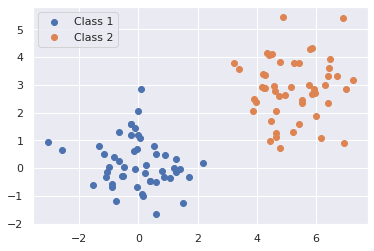

In [7]:
# Answer
# To do
X1 = gaussian_sample(mu=[0, 0])
X2 = gaussian_sample(mu=[5, 3])
# End to do

plt.scatter(*X1.T, label='Class 1')
plt.scatter(*X2.T, label='Class 2')
plt.legend();

## Question 3
>Based on the following code, implement a linear discriminant classifier, taking as parameters an $n \times 2$ data matrix and a size-$n$ array of labels.

In [8]:
# Answer
class LDA():
    """
        LDA classifier for two classes.
    """
    def __init__(self):
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        # To do
        indp, indn = y==y.max(), y==y.min()  # Mask for each class
        pi = np.mean(indp)  # Prior probability estimation
        # Estimate covariance matrix and means
        cov = pi*np.cov(X[indp].T) + (1-pi)*np.cov(X[indn].T)
        invcov = np.linalg.inv(cov)  # Inverse covariance matrix
        mu1 = X[indp].mean(axis=0)
        mu2 = X[indn].mean(axis=0)
        # Compute direction and intercept
        self.coef_ = invcov.dot(mu1-mu2)
        self.intercept_ = 0.5*(mu2.dot(invcov.dot(mu2)) - mu1.dot(invcov.dot(mu1))) + np.log(pi/(1-pi))
        # End to do
        return self

    def decision_function(self, X):
        # Compute decisions
        decisions = X.dot(self.coef_) + self.intercept_
        return decisions

    def predict(self, X):
        # Compute predictions
        # To do
        predictions = (self.decision_function(X) > 0)*2 - 1
        # End to do
        return predictions

>Create the data matrix `X` and the array of lablels `y` based on the samples generated previously and fit a linear discriminant classifier.
Plot the data and the decision boundary with the function `plot_frontiere` (for instance with `plot_frontiere(lda, X, y)`).

In [9]:
def plot_frontiere(clfs, data=None, data_labels=None, label=None, num=500, figure=True):
    """
        Plot the frontiere fun(x)=0 of the classifier clf within the same range as the one
        of the data.
        Input:
            clfs: classifier or list of classifiers
            data: input data (X)
            data_labels: data labels (y)
            label: classifier labels as a list
            num: discretization parameter
            figure: create a new figure
    """
    if not hasattr(clfs, '__iter__'):
        clfs = [clfs]
    if label is not None and not hasattr(label, '__iter__'):
        label = [label]
        
    xmin, ymin = data.min(axis=0)
    xmax, ymax = data.max(axis=0)
    x, y = np.meshgrid(np.linspace(xmin, xmax, num), np.linspace(ymin, ymax))
    
    if figure:
        plt.figure(figsize=(7, 7))
#     plt.scatter(*data.T, c=data_labels, cmap='plasma')
    for icl, cl in enumerate(np.unique(data_labels)):
        plt.scatter(*data[data_labels==cl].T, label='Class {0:d}'.format(icl+1))
        
    for i, clf in enumerate(clfs):
        z = clf.decision_function(np.c_[x.ravel(), y.ravel()]).reshape(x.shape)
        cs = plt.contour(x, y, z, [0], colors='r')
        if label is not None:
            cs.levels = [label[i]]
            plt.gca().clabel(cs)
    if figure:
        plt.axis('image')
    minx, miny = data[:, 0].min(), data[:, 1].min()
    diffx, diffy = data[:, 0].max() - minx, data[:, 1].max() - miny
    plt.axis([minx - 0.1*diffx, minx + 1.1*diffx, miny - 0.1*diffy, miny + 1.1*diffy])
    plt.legend(loc="best")

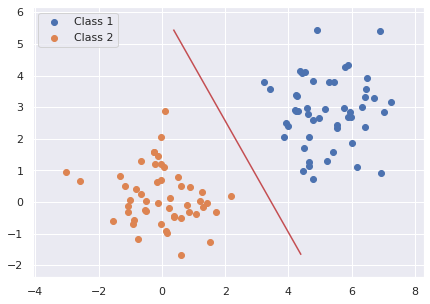

In [10]:
# Answer
X = np.r_[X1, X2]
y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]

# To do
lda = LDA()
lda.fit(X, y)

plot_frontiere(lda, X, y)
# End to do

## Question 4
>Do the same with quadratic discriminant analysis.
Then, compare LDA and QDA (you can use `plot_frontiere` with a list of classifiers, for instance `plot_frontiere([lda, qda], X, y, label=["LDA", "QDA"])`).

In [11]:
# Answer
class QDA():
    """
        QDA classifier for two classes.
    """
    def __init__(self):
        self.quad_ = None
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        # To do
        indp, indn = y==y.max(), y==y.min()  # Mask for each class
        pi = np.mean(indp)  # Prior probability estimation
        # Estimate covariance matrix and means
        cov1 = np.cov(X[indp].T)
        cov2 = np.cov(X[indn].T)
        invcov1 = np.linalg.inv(cov1)
        invcov2 = np.linalg.inv(cov2)
        mu1 = X[indp].mean(axis=0)
        mu2 = X[indn].mean(axis=0)
        # Compute direction and intercept
        self.quad_ = invcov2 - invcov1
        self.coef_ = invcov1@mu1 - invcov2@mu2
        self.intercept_ = 0.5*(mu2@invcov2@mu2- mu1@invcov1@mu1) -0.5*np.log(np.linalg.det(cov1) / np.linalg.det(cov2)) + np.log(pi/(1-pi))
        # End to do
        return self

    def decision_function(self, X):
        # Compute decisions
        decisions = 0.5*np.diag(X@self.quad_@X.T) + X@self.coef_ + self.intercept_
        return decisions

    def predict(self, X):
        # Compute predictions
        # To do
        predictions = (self.decision_function(X) > 0)*2 - 1
        # End to do
        return predictions

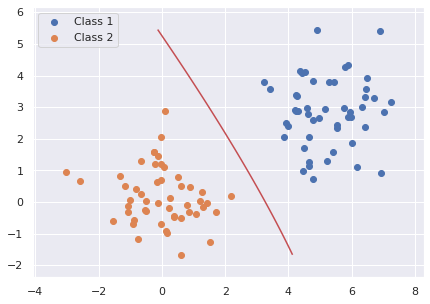

In [12]:
# Answer
qda = QDA()
qda.fit(X, y)

plot_frontiere(qda, X, y)

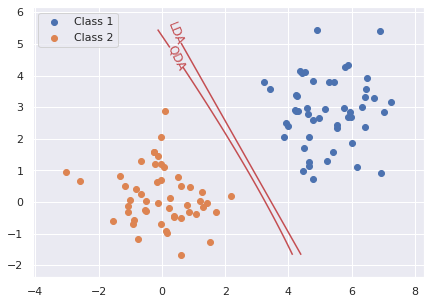

In [13]:
# Answer
# Discriminant analysis
lda.fit(X, y)
qda.fit(X, y)

# Plot frontieres and class means
plot_frontiere([lda, qda], X, y, label=["LDA", "QDA"])
# End to do

## Question 5
>Add a parameter `naiveBayes` (with default value `False`) to the class QDA and modify the latter in order to implement a Gaussian Naive Bayes classifier.

In [14]:
# Answer
class QDA():
    """
        QDA classifier for two classes.
    """
    def __init__(self, naiveBayes=False):
        self.quad_ = None
        self.coef_ = None
        self.intercept_ = None
        self.naiveBayes = naiveBayes
        
    # To do
    def fit(self, X, y):
        indp, indn = y==y.max(), y==y.min()  # Mask for each class
        pi = np.mean(indp)  # Prior probability estimation
        # Estimate covariance matrix and means
        cov1 = np.cov(X[indp].T)
        cov2 = np.cov(X[indn].T)
        if self.naiveBayes:
            cov1 = np.diag(np.diag(cov1))
            cov2 = np.diag(np.diag(cov2))
        invcov1 = np.linalg.inv(cov1)
        invcov2 = np.linalg.inv(cov2)
        mu1 = X[indp].mean(axis=0)
        mu2 = X[indn].mean(axis=0)
        # Compute direction and intercept
        self.quad_ = invcov2 - invcov1
        self.coef_ = invcov1@mu1 - invcov2@mu2
        self.intercept_ = 0.5*(mu2@invcov2@mu2- mu1@invcov1@mu1) -0.5*np.log(np.linalg.det(cov1) / np.linalg.det(cov2)) + np.log(pi/(1-pi))
        return self

    def decision_function(self, X):
        # Compute decisions
        decisions = 0.5*np.diag(X@self.quad_@X.T) + X@self.coef_ + self.intercept_
        return decisions

    def predict(self, X):
        # Compute predictions
        predictions = (self.decision_function(X) > 0)*2 - 1
        return predictions
    # End to do

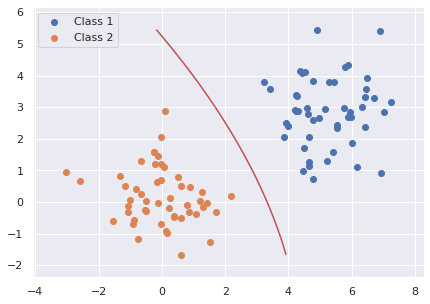

In [15]:
# Answer
naive = QDA(naiveBayes=True)
naive.fit(X, y)

plot_frontiere(naive, X, y)

## Question 6
>Analyze the behavior of LDA, QDA and Naive Bayes when they are faced to anisotropic Gaussian samples (in particular, check if the frontiere is the bisector of the line segment for which the extremities are both class centers), and then to Gaussian samples with different covariance matrices.

<Figure size 720x1440 with 0 Axes>

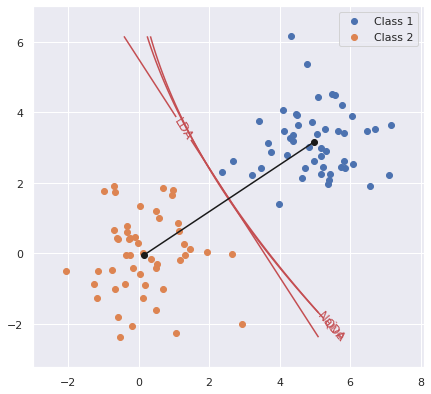

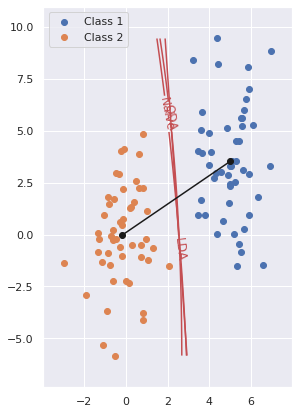

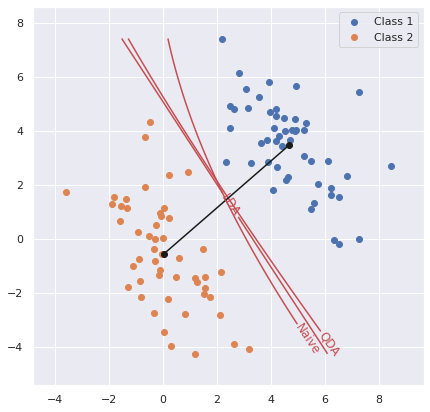

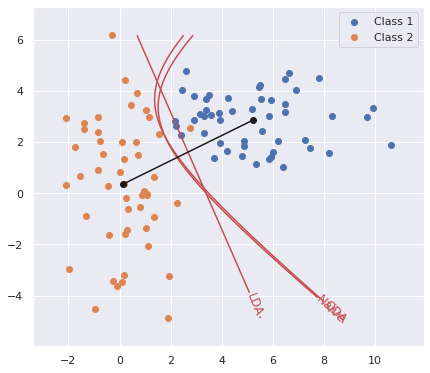

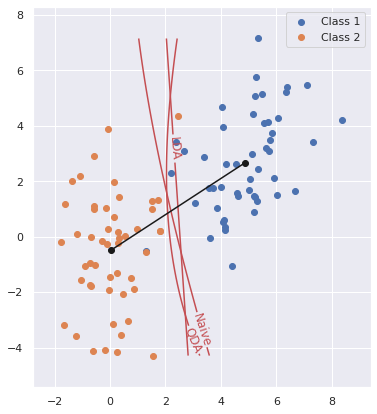

In [16]:
# Answer
lda = LDA()
qda = QDA()
naive = QDA(naiveBayes=True)

# Gassian parameters
mu1 = mu = [0, 0]
mu2 = [5, 3]

plt.figure(figsize=(10, 20))
for (p1, p2) in [((1, 1, 0), ) * 2,
                  ((1, 5, 0), ) * 2,
                  ((1, 5, np.pi/6), ) * 2,
                  ((1, 5, 0), (5, 1, 0)),
                  ((1, 5, 0), (5, 1, np.pi/3))]:
    # Dataset
    X1 = gaussian_sample(mu1, *p1)
    X2 = gaussian_sample(mu2, *p2)
    
    # To do
    X = np.r_[X1, X2]
    y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0])]
    
    # Discriminant analysis
    lda.fit(X, y)
    qda.fit(X, y)
    naive.fit(X, y)
    
    # Plot frontieres and class means
    plot_frontiere([lda, qda, naive], X, y, label=["LDA", "QDA", "Naive"])
    # End to do
    
    # Plot class means
    # Class means
    mu1_emp = X[y==y.max()].mean(axis=0)
    mu2_emp = X[y==y.min()].mean(axis=0)
    plt.plot([mu1_emp[0], mu2_emp[0]], [mu1_emp[1], mu2_emp[1]], 'ko-')  # Plot the line between class means

## Question 7
>Compare methods on the following dataset (class $-1$ is not Gaussian).

In [17]:
X1 = gaussian_sample(mu=[0, 0])
X2 = gaussian_sample(mu=[5, 3], n=25)
X3 = gaussian_sample(mu=[8, 9], n=25)

X = np.r_[X1, X2, X3]
y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0]), -np.ones(X3.shape[0])]

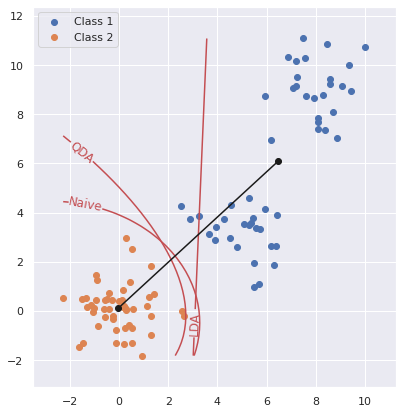

In [18]:
# Answer
# Discriminant analysis
lda.fit(X, y)
qda.fit(X, y)
naive.fit(X, y)

# Class means
mu1_emp = X[y==y.max()].mean(axis=0)
mu2_emp = X[y==y.min()].mean(axis=0)

# Plot frontieres and class means
plot_frontiere([lda, qda, naive], X, y, label=["LDA", "QDA", "Naive"])
plt.plot([mu1_emp[0], mu2_emp[0]], [mu1_emp[1], mu2_emp[1]], 'ko-')  # Plot the line between class centers

## Question 8
>What about with this dataset (class $-1$ is Gaussian but with an outlier)?

In [19]:
# Dataset
X1 = gaussian_sample(mu=[0, 0])
X2 = gaussian_sample(mu=[5, 3], n=49)
X3 = gaussian_sample(mu=[20, 20], n=1).reshape(1, -1)

X = np.r_[X1, X2, X3]
y = np.r_[np.ones(X1.shape[0]), -np.ones(X2.shape[0]), -np.ones(X3.shape[0])]

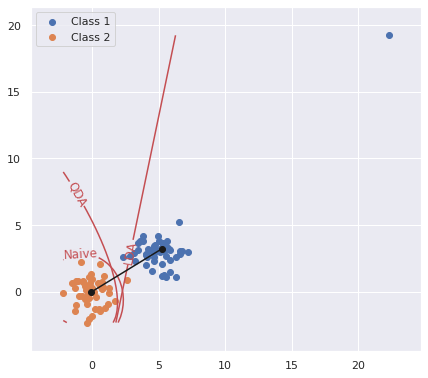

In [20]:
# Answer
# Discriminant analysis
lda.fit(X, y)
qda.fit(X, y)
naive.fit(X, y)

# Class means
mu1_emp = X[y==y.max()].mean(axis=0)
mu2_emp = X[y==y.min()].mean(axis=0)

# Plot frontieres and class means
plot_frontiere([lda, qda, naive], X, y, label=["LDA", "QDA", "Naive"])
plt.plot([mu1_emp[0], mu2_emp[0]], [mu1_emp[1], mu2_emp[1]], 'ko-')  # Plot the line between class centers

## Question 9
>Implement a Naive Bayes classifier for data with a first explicative variable which is Gaussian and a second explicative variable which is Bernoulli distributed.
Illustrate its proper functioning with the following dataset.

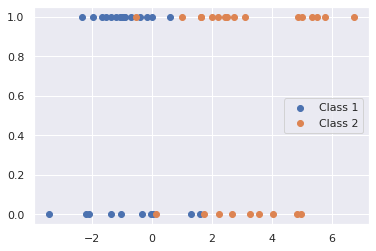

In [21]:
n = 50
X = np.r_[np.c_[np.random.randn(n//2)*2+3, np.random.binomial(1, .7, n//2)],
          np.c_[np.random.randn(n//2)-1, np.random.binomial(1, .4, n//2)]]
y = np.r_[np.ones(n//2), -np.ones(n//2)]

plt.scatter(*X[y==-1].T, label='Class 1')
plt.scatter(*X[y==1].T, label='Class 2')
plt.legend()

In [22]:
# Answer
class GaussBerNB():
    """
        Gaussian x Bernoulli Naive Bayes for two classes.
    """
    def __init__(self):
        self.quad_ = None
        self.coef_ = None
        self.intercept_ = None
        
    def fit(self, X, y):
        # To do
        indp, indn = y==y.max(), y==y.min()  # Mask for each class
        pi = np.mean(indp)  # Prior probability estimation
        # Estimate covariance matrix and means
        var1 = X[indp, 0].var()
        var2 = X[indn, 0].var()
        mu1 = X[indp, 0].mean()
        mu2 = X[indn, 0].mean()
        p1 = np.mean(X[indp, 1]>.5)
        p2 = np.mean(X[indn, 1]>.5)
        # Compute direction and intercept
        self.quad_ = 1/var2 - 1/var1
        self.coef_ = np.r_[mu1/var1 - mu2/var2, np.log(p1/(1-p1)) + np.log((1-p2)/p2)]
        self.intercept_ = 0.5*(mu2**2/var2 - mu1**2/var1) + np.log(pi/(1-pi)) + .5*np.log(var2/var1) + np.log((1-p1)/(1-p2))
        # End to do
        return self

    def decision_function(self, X):
        # Compute decisions
        decisions = X[:, 0]**2 * self.quad_/2 + X@self.coef_ + self.intercept_
        return decisions

    def predict(self, X):
        # Compute predictions
        # Todo
        predictions = (self.decision_function(X) > 0)*2 - 1
        # End todo
        return predictions

(-0.5, 1.5)

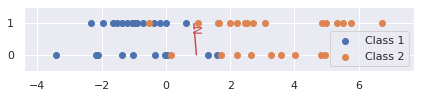

In [23]:
# Answer
naive = GaussBerNB()
naive.fit(X, y)

plot_frontiere(naive, X, y, label="Naive Bayes")
plt.ylim((-.5, 1.5))